In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import chi2_contingency, chi2 
from scipy import stats
from scipy.stats import norm
from tqdm.auto import tqdm
%matplotlib inline

### Задание 1

Написать функцию, которая будет считать retention игроков по дням от даты регистрации игрока

In [163]:
#Чтение данных
df_reg = pd.read_csv('problem1-reg_data.csv', sep=';')
df_auth = pd.read_csv('problem1-auth_data.csv', sep=';')

### Краткое описание полученных датасетов:

**df_reg**

* Записей о регистрации - 1 000 000; (shape)
* Значения NULL не обнаружены; (isna().sum())
* Дубликаты не обнаружены (duplicated().sum())
* Типы данных соответствуют содержимому (dtypes)


**df_auth**

* Записей об авторизациях - 9 601 013; (shape)
* Значения NULL не обнаружены; (isna().sum())
* Дубликаты не обнаружены (duplicated().sum())
* Типы данных соответствуют содержимому (dtypes)
* Количество уникальных пользователей совпадает с количеством записей о регистрации; (nunique())

*Для тестирования функции объём данных считаю избыточным. Создадим датасет, содержащий 10 000 последних записей*

In [164]:
df_test = df_reg.tail(10000)

Требуемая функция

In [165]:
def retention(reg, auth):
    #Объединение данных в общий датасет
    merge_data = reg.merge(auth, on='uid')
    
    #Преобразование столбцов с датами в более удобный для работы формат
    merge_data.reg_ts = pd.to_datetime(merge_data.reg_ts, unit='s').dt.date
    merge_data.auth_ts = pd.to_datetime(merge_data.auth_ts, unit='s').dt.date
    
    #Принудительная мена типа данных
    merge_data['reg_ts'] = merge_data['reg_ts'].astype('datetime64[ns]')
    merge_data['auth_ts'] = merge_data['auth_ts'].astype('datetime64[ns]')

    
    #Вычисление разницы в днях между входом и регистрацией
    merge_data['diff'] = (merge_data['auth_ts'] - merge_data['reg_ts']).dt.days
    
    #Группировка пользователей на группы согласно периодам в днях
    user_group = merge_data.groupby(['reg_ts', 'diff']).agg({'uid':'nunique'}).reset_index()
    user_group = user_group.rename(columns={'reg_ts': 'group', 'diff': 'group_time'})

        
    #Преобразование таблицы
    user_group_pivot = user_group.pivot(index='group', columns='group_time', values='uid')
    all_reg = user_group_pivot[0]
    
    #Вычисление процента заходов посетителей от общего числа зарегистрированных
    retention_do = user_group_pivot.divide(all_reg, axis=0).round(2)
    
    #Визуализируем полученные данные
    plt.figure(figsize=(24, 10))
    sns.heatmap(retention_do, mask = retention_do.isnull(), annot=True, fmt='.2%', vmin=0.0, vmax=0.07)
    plt.title('Retention Rate')
    plt.ylabel('Дата регистрации')
    plt.xlabel('Номер дня')

Тест работы функции на ограниченных данных

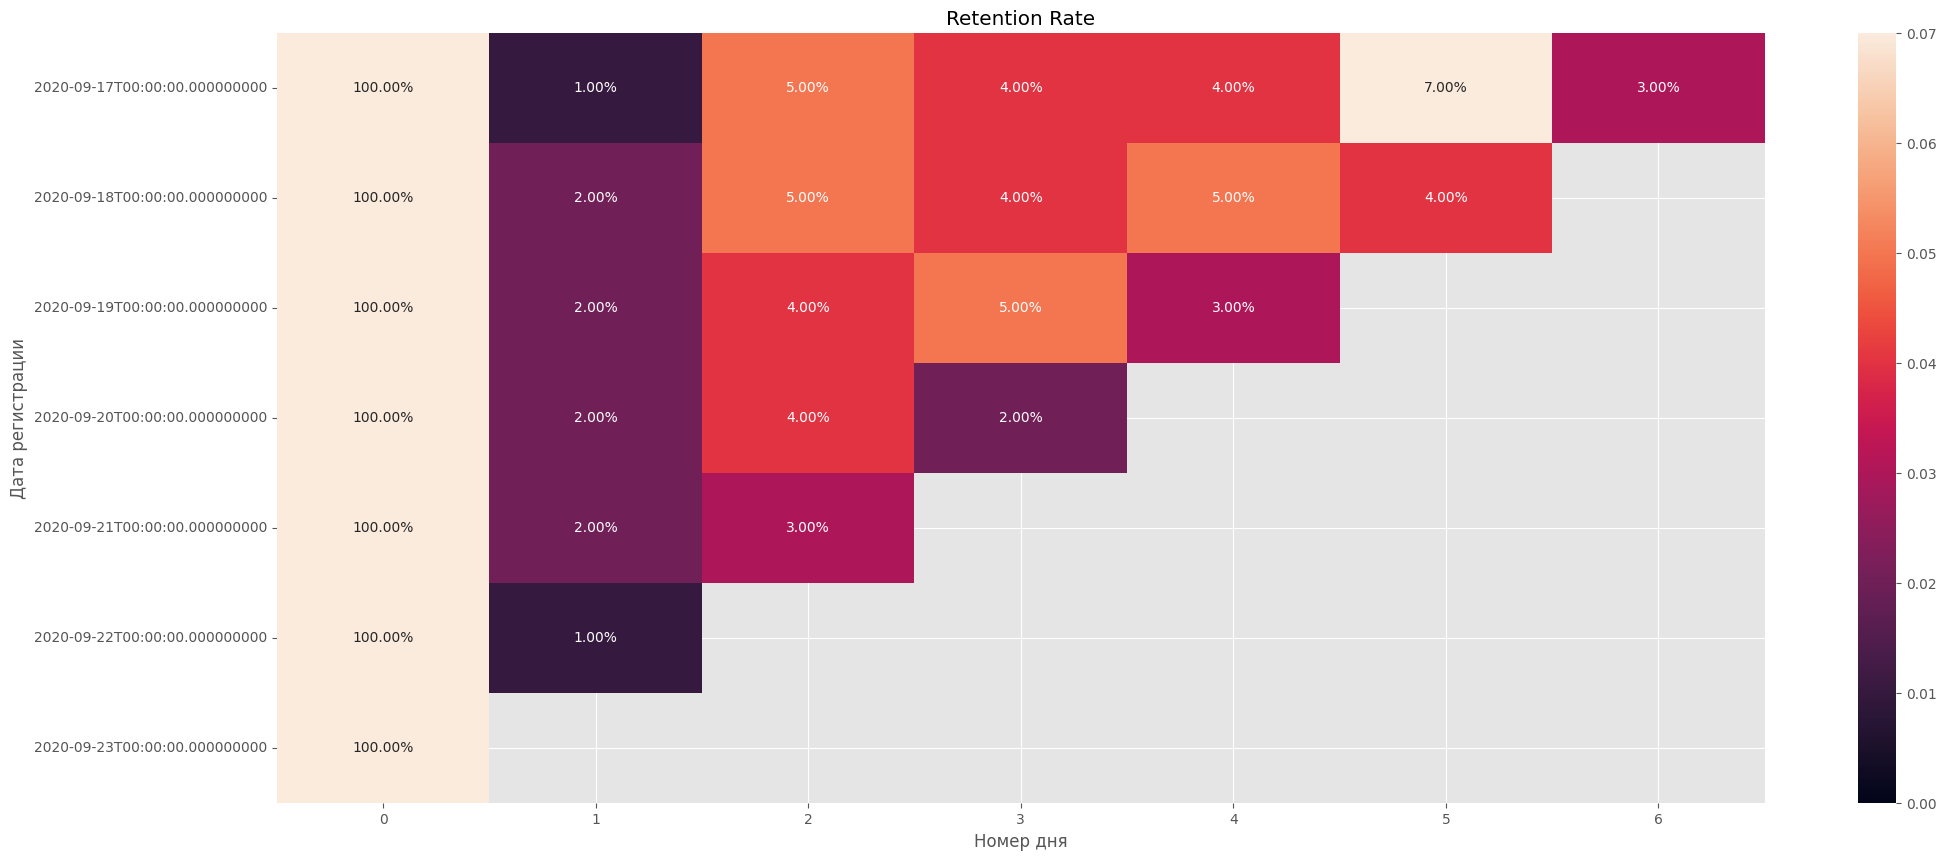

In [166]:
retention(df_test, df_auth)

### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [167]:
#Чтение данных
df = pd.read_csv('task_2.csv',sep=';')

### Краткое описание полученного датасета:

* Записей - 404 770 (shape);
* Значения NULL не обнаружены; (isna().sum())
* Дубликаты не обнаружены (duplicated().sum())
* Типы данных соответствуют содержимому (dtypes)

*Для удобства дальнейших действий следует разделить предлагаемый датасет на 2 по критерию групп*

In [168]:
group_control = df.query('testgroup == "a"')
group_test = df.query('testgroup == "b"')

Для оценки эффективности наборов предложений стоит использовать следующий набор метрик:

* ARPU - средний доход от каждого пользователя (указано в задании);
* ARPPU - средний доход с каждого платящего пользователя;
* CR - конверсия - соотношение числа посетителей, выполнивших целевое действие, и общего числа посетителей.

*Для понимания дальнейших действий, необходимо просчитать данные показатели для каждой из групп и выявить различия*

In [169]:
#ARPU

arpu_control = round(group_control.revenue.sum() / group_control.user_id.nunique(), 2)
arpu_test = round(group_test.revenue.sum() / group_test.user_id.nunique(), 2)
result = round(arpu_test*100 / arpu_control - 100, 2)

print('ARPU контрольной группы:', arpu_control, '\nARPU тестовой группы:', arpu_test, '\nARPU тестовой группы больше на', result, '%')

ARPU контрольной группы: 25.41 
ARPU тестовой группы: 26.75 
ARPU тестовой группы больше на 5.27 %


In [170]:
#ARPPU

arppu_control = round(group_control.revenue.sum() / group_control.query('revenue != 0').user_id.nunique(), 2)
arppu_test = round(group_test.revenue.sum() / group_test.query('revenue != 0').user_id.nunique(), 2)
result = round(arppu_test*100 / arppu_control - 100, 2)

print('ARPPU контрольной группы:', arpu_control, '\nARPPU тестовой группы:', arpu_test, '\nARPPU тестовой группы больше на', result, '%')

ARPPU контрольной группы: 25.41 
ARPPU тестовой группы: 26.75 
ARPPU тестовой группы больше на 12.75 %


In [171]:
#CR

cr_control = round(group_control.query('revenue != 0').user_id.nunique() / group_control.user_id.nunique()*100, 2)
cr_test = round(group_test.query('revenue != 0').user_id.nunique() / group_test.user_id.nunique()*100, 2)
result = round(cr_control*100 / cr_test - 100, 2)

print('CR контрольной группы:', cr_control, '\nCR тестовой группы:', cr_test, '\nCR контрольной группы больше на', result, '%')

CR контрольной группы: 0.95 
CR тестовой группы: 0.89 
CR контрольной группы больше на 6.74 %


Согласно полученным результатам, данные конверсии выше в контрольной группе, что может говорить о неэффективности наборов акционных предложений. В тоже время, денежные метрики у тестовой группы выше. 

*Необходимо оценить данные различия через стат значимость*

Т.к. CR - единственный показатель, в котором лучше контрольная группа, проверку на стат значимость следует начать с него.

In [172]:
#Предобработка данных для тестирования

#Создаем колонку с отображением факта покупки\оплаты
df['payment'] = df.revenue.apply(lambda x: 1 if x > 0 else 0)

#Строим перекрестную таблицу
pd.crosstab(df.testgroup, df.payment)

payment,0,1
testgroup,,
a,200175,1928
b,200862,1805


Проверяем стат значимость взаимосвязи платящих пользователей и их принадлежности к одной из групп с помощью хи-квадрат

* Н0 - взаимосвязи между платящими пользователями и группой, к которой они принадлежат нет
* Н1 - взаимосвязь между платящими пользователями и группой, к которой они принадлежат есть

In [173]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.testgroup, df.payment))
stat, p

(4.374729521260405, 0.03647561892312613)

Т.к. p-value меньше 0,05 мы отклоняем нулевую гипотезу, что позволяет нам утверждать о том, что изменение конверсии весьма вероятно взаимосвязано с введением нового алгоритма. 

*Далее стоит разобраться в остальных метриках. Для этого стоит взглянуть на распределения платежей по пользователям в каждой из групп*

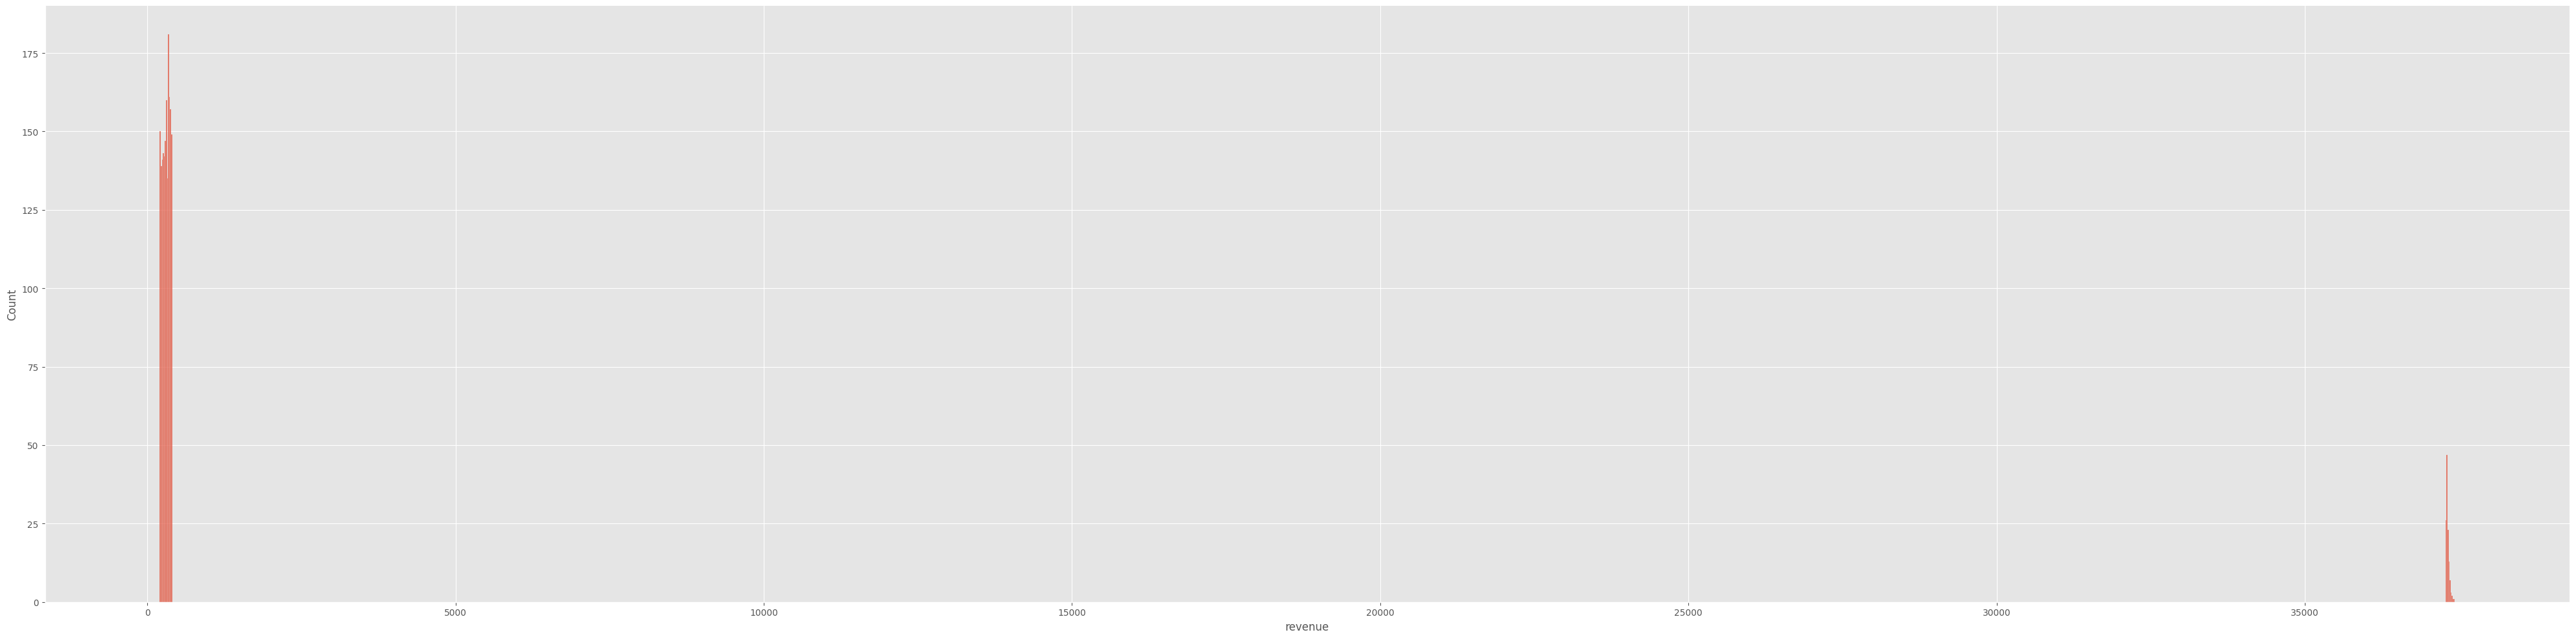

In [174]:
group_control_pay = group_control.query('revenue > 0')
sns.displot(group_control_pay.revenue, height=10, aspect=4)

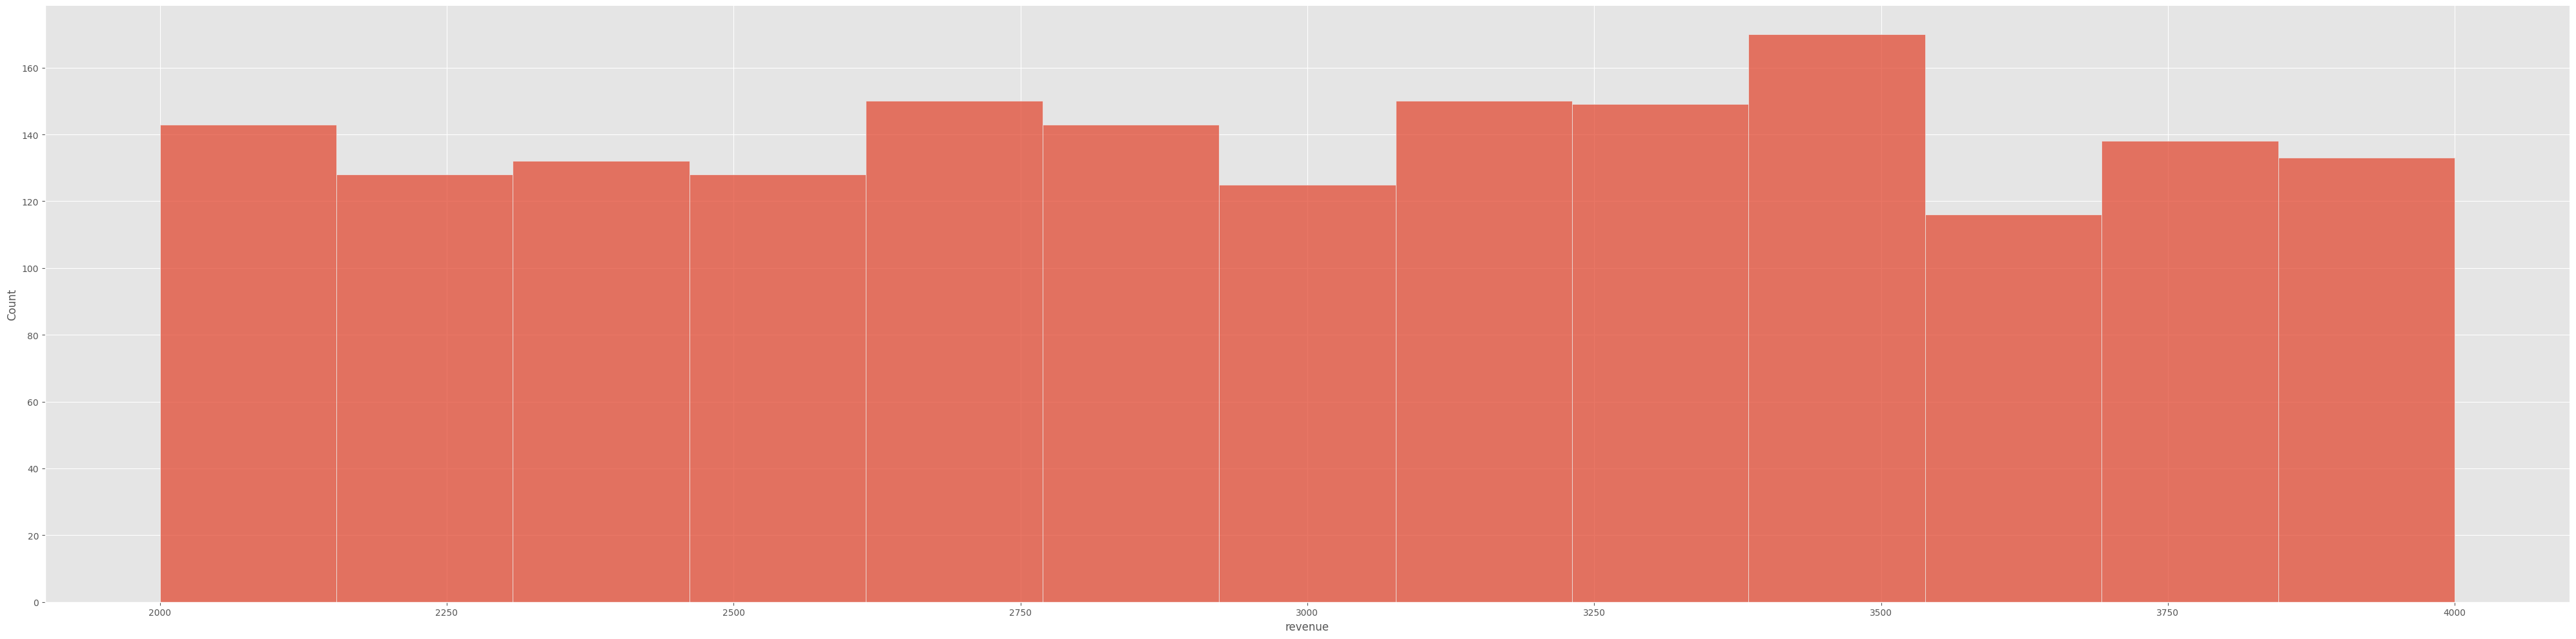

In [175]:
group_test_pay = group_test.query('revenue > 0')
sns.displot(group_test_pay.revenue, height=10, aspect=4)

В контрольной группе имеется большое количество выбросов с суммой платежей более 35 000. Изучим данный факт более подробно

In [176]:
group_control_pay.query('revenue > 35000')

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


Учитывая, что по условию задачи в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667, разница составляет 123 игрока - ровно то количество игроков, которые платят аномально большие суммы. 

Таким образом, стоит проверить показатели без данных игроков, т.е. учесть их как ошибку в данных. Тогда Наши показатели будут иметь следующий вид

In [177]:
#Удаляем данные о больших покупках
group_control_test = group_control.query('revenue < 35000')

In [178]:
#Рассчитываем все показатели заново:

#ARPU

arpu_control = round(group_control_test.revenue.sum() / group_control_test.user_id.nunique(), 2)
arpu_test = round(group_test.revenue.sum() / group_test.user_id.nunique(), 2)
result = round(arpu_test*100 / arpu_control - 100, 2)

print('ARPU контрольной группы:', arpu_control, '\nARPU тестовой группы:', arpu_test, '\nARPU тестовой группы больше на', result, '%')

#ARPPU

arppu_control = round(group_control_test.revenue.sum() / group_control_test.query('revenue != 0').user_id.nunique(), 2)
arppu_test = round(group_test.revenue.sum() / group_test.query('revenue != 0').user_id.nunique(), 2)
result = round(arppu_test*100 / arppu_control - 100, 2)

print('ARPPU контрольной группы:', arpu_control, '\nARPPU тестовой группы:', arpu_test, '\nARPPU тестовой группы больше на', result, '%')

#CR

cr_control = round(group_control_test.query('revenue != 0').user_id.nunique() / group_control_test.user_id.nunique()*100, 2)
cr_test = round(group_test.query('revenue != 0').user_id.nunique() / group_test.user_id.nunique()*100, 2)
result = round(cr_control*100 / cr_test - 100, 2)

print('CR контрольной группы:', cr_control, '\nCR тестовой группы:', cr_test, '\nCR контрольной группы больше на', result, '%')

ARPU контрольной группы: 2.7 
ARPU тестовой группы: 26.75 
ARPU тестовой группы больше на 890.74 %
ARPPU контрольной группы: 2.7 
ARPPU тестовой группы: 26.75 
ARPPU тестовой группы больше на 893.08 %
CR контрольной группы: 0.89 
CR тестовой группы: 0.89 
CR контрольной группы больше на 0.0 %


Таким образом, если принять данные за выбросы, то имеем кратный рост показателей доходности от пользователей в тестовой группе при равнстве конверсии, что может служить однозначным основанием для вывода о том, что **наборы акционных предложений имеют влияние на рост прибыли**. 

Теперь стоит учесть исключенные данные в расчетах и посмотреть результаты. 

*Для определения следующих методов необходимо проверить данные на нормальность с помощью функциb scipy.stats.normaltest()*
* Н0 - Данные распределены нормально
* Н1 - Данные распределены не нормальным образом

In [179]:
stats.normaltest(group_control_pay.revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [180]:
stats.normaltest(group_test_pay.revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

Таким образом, получаем статистически значимое доказательство что распределения не нормальные для обоих показателей. На мой взгляд, ввиду ненормальности распределений, T-тест применять нельзя. Потому, чтобы установить статистическую значимость изменений показателей ARPU и ARPPU необходимо использовать метод Bootstrap. 

* Н0 - Изменения показателя статистически не значимы для групп
* Н1 - Изменения показателя статистически значимы для групп

In [181]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('grey')
        else: 
            bar.set_facecolor('grey')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

100%|██████████| 1000/1000 [00:11<00:00, 87.40it/s]


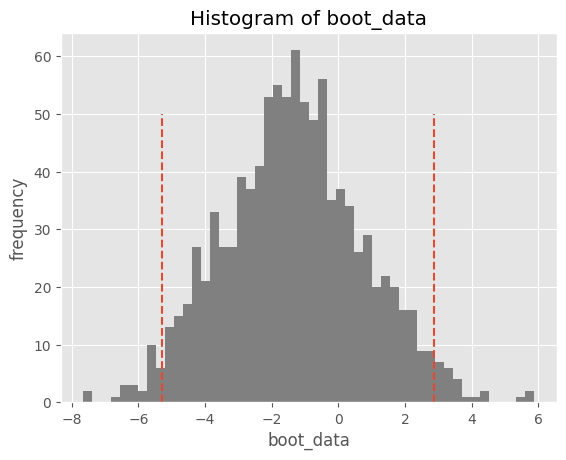

{'quants':               0
 0.025 -5.296065
 0.975  2.859366,
 'p_value': 0.524621794923245}

In [182]:
get_bootstrap(group_control.revenue, group_test.revenue)

Т.к. 0 находится внутри доверительного интервала, то нельзя считать отличия в ARPU статистически значимыми. 

*Проведем такую же проверку для ARPPU*

100%|██████████| 1000/1000 [00:00<00:00, 2789.39it/s]


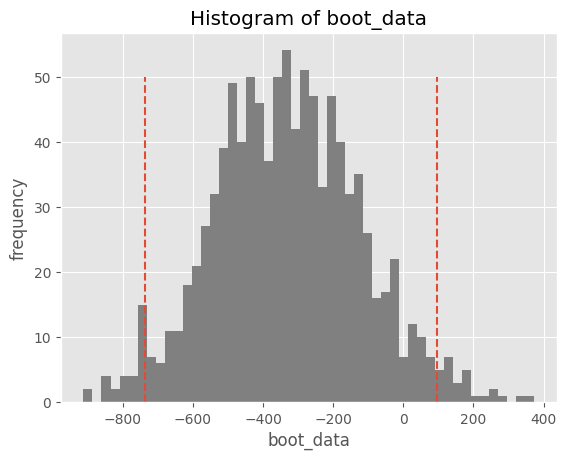

{'quants':                 0
 0.025 -737.366507
 0.975   95.754046,
 'p_value': 0.11223400801833641}

In [183]:
get_bootstrap(group_control_pay.revenue, group_test_pay.revenue)

Т.к. 0 находится внутри доверительного интервала, то нельзя считать отличия в ARPPU статистически значимыми. 

### Общий вывод

По результатам проведенного А/В теста нельзя на 100% утверждать, что набор акционных предложений для любой из групп лучше. 

Если смотреть по структуре данных, более полное понимание ситуации можно получить изучив данные о больших покупках в контрольной группе, в частности о причинах их возникновения и причинах их отсутствия в тестовой группе. На мой взгляд, эти данные несут в себе решающие аргументы для полного ответа на поставленное условие задачи. 

При учете этих данных было установлено, что:
* Конверсия в контрольной группе выше чем в тестовой и это статистически значимый результат;
* Показатели ARPU и ARPPU выше в тестовой группе, но это не имеет статистической значимости.

## Задание 3
#### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

### Ответ

Основными метриками для оценки результатов такого события могут выступать:
* DAU(дневная аудитория) и MAU(месячная аудитория) - обе метрики показывают количество уникальных пользователей за определенное время (за день или месяц). Необходимо провести сравнение данных во время события с данными без событий.
* CR(конверсия) - соотношение числа посетителей, выполнивших целевое действие (вход в игру, покупка), и общего числа посетителей.
* RR(удержание клиентов) - в рамках данного показателя будут интересовать те игроки, которые давно не заходили в игру, но вернулись во время события
* ARPPU - средний доход на платящего пользователя.
* ARPU  - средний доход с привлечённого пользователя.

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Ответ

Набор метрик потребует наличия в своем составе таких показателей как Churn rate (отток клиентов) и ASL (средняя продолжительность сессии)